#### LIBRERÍAS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

In [2]:
from scipy.optimize import curve_fit
from scipy import integrate
from statistics import median, mean

#### FUNCIONES

Fits de electrones. 

_flux_pos_tot()_ : fit total

_flux_pos_diff()_ : fit de la componente de positrones de origen difuso

_flux_pos_source()_ : fit de la componente de positrones de origen fuente

In [3]:
# Fit de los datos

# Parámetros:
# eff_pot = 1.1 GeV # E_s_1 = 1.23 GeV # C_s = 6.8e-5 GeV # gamma_s = -2.58 # C_d = 6.51e-2 GeV # gamma_d = -4.07 
# E_gorro = E + eff_pot # E_a = 7 GeV # E_b = 60 GeV

# Fit datos
def flux_pos_tot(E,eff_pot,C_d,E_a,gamma_d,C_s,E_b,gamma_s,E_s_1):
    E_gorro = E + eff_pot
    term1 = (E/E_gorro)**2 # término debido a la modulación solar
    term2 = C_d*(E_gorro/E_a)**gamma_d + C_s*(E_gorro/E_b)**gamma_s*np.exp(-E_gorro*E_s_1/10**3)
    return(term1*term2)

# Fit diffuse term
def flux_pos_diff(E,eff_pot,C_d,E_a,gamma_d):
    E_gorro = E + eff_pot
    term1 = (E/E_gorro)**2
    term_diff = C_d*(E_gorro/E_a)**gamma_d
    return(term1*term_diff)

#Fit source term
def flux_pos_source(E,eff_pot,C_s,E_b,gamma_s,E_s_1):
    E_gorro = E + eff_pot
    term1 = (E/E_gorro)**2
    term2 = C_s*(E_gorro/E_b)**gamma_s*np.exp(-E_gorro*E_s_1/10**3)
    return(term1*term2)    

Cálculo de $\chi^2$

In [4]:
def chi_2(val,fit,error):
    xi2_v = []
    for i in range(0,len(val)):
        xi2_v.append((val[i] - fit[i])**2/error[i]**2)
    xi2_1 = sum(xi2_v)
    xi2_2 = (len(xi2_v)-7)  
    xi2 = xi2_1/xi2_2  
    return xi2

#### CARGAR LOS ARCHIVOS Y TRATARLOS

In [5]:
data = pd.read_csv('table-si-p.csv')

In [6]:
data.columns.values[2] = 'E_bind'
data.columns.values[3] = 'E_bind_syst'
data.columns.values[-7] = 'phi'
data.columns.values[-6] = 'phi_stat'
data.columns.values[-5] = 'phi_syst_tmpl'
data.columns.values[-4] = 'phi_syst_cc'
data.columns.values[-3] = 'phi_syst_acc'
data.columns.values[-2] = 'phi_syst_unf'
data.columns.values[-1] = 'phi_syst'

In [7]:
#multiplico phi  y el error de phi por E^3 para plotearlo

#añado la columna con los nuevos valores de phi*E^3
data = data.assign(phi_E3 = data.phi.mul(data.E_bind**3))

# calculo primero el error de phi como media geométrica 
# del error sistemático y el error estadístico y lo añado como columnda al df
data = data.assign(phi_error = np.sqrt((data.phi_syst**2).add(data.phi_stat**2)))

#y añado la columna con los nuevos valores del error de phi*E3
data = data.assign(phi_error_E3 = data.phi_error.mul(data.E_bind**3))

data.head()

,E1,E2,E_bind,E_bind_syst,N,N_stat,phi,phi_stat,phi_syst_tmpl,phi_syst_cc,phi_syst_acc,phi_syst_unf,phi_syst,phi_E3,phi_error,phi_error_E3
0,0.50,0.65,0.57,0.02,1149,47,2.669,0.109,0.075,0.0,0.107,0.053,0.141,0.494280,0.178219,0.033005
1,0.65,0.82,0.73,0.02,12911,144,2.576,0.029,0.046,0.0,0.083,0.044,0.105,1.002108,0.108931,0.042376
2,0.82,1.01,0.91,0.03,26583,192,2.272,0.016,0.022,0.0,0.060,0.031,0.071,1.712113,0.072780,0.054845
3,1.01,1.22,1.11,0.03,40179,225,1.929,0.011,0.013,0.0,0.043,0.019,0.049,2.638160,0.050220,0.068682
4,1.22,1.46,1.33,0.03,54417,254,1.528,0.007,0.009,0.0,0.027,0.014,0.032,3.594829,0.032757,0.077065


#### PARÁMETROS

In [8]:
popt,pcov = curve_fit(flux_pos_tot, data.E_bind, data.phi, sigma=data.phi_error, p0=[1.1, 6.51e-2, 7, -4.07, 6.8e-5, 60, -2.58, 1.23])
popt

array([ 1.07764234e+00,  6.57565194e-02,  6.98108444e+00, -4.02979579e+00,
        7.07259702e-05,  5.88553170e+01, -2.54828005e+00,  1.36963684e+00])

#### FITS

In [9]:
fit_tot = flux_pos_tot(data.E_bind,E_a = 7, E_b = 60, eff_pot = 1.1, E_s_1 = 1.23,
             C_s = 6.8e-5, gamma_s = -2.58, C_d = 6.51e-2, gamma_d = -4.07)

fit_diff = flux_pos_diff(data.E_bind,E_a = 7, eff_pot = 1.1, C_d = 6.51e-2, gamma_d = -4.07)

fit_source = flux_pos_source(data.E_bind, E_b = 60, eff_pot = 1.1, E_s_1 = 1.23, C_s = 6.8e-5, gamma_s = -2.58)


In [10]:
fit_tot_param = flux_pos_tot(data.E_bind, eff_pot = popt[0], C_d = popt[1], E_a = popt[2], gamma_d = popt[3], 
                       C_s = popt[4], E_b= popt[5], gamma_s=popt[6], E_s_1=popt[7])

fit_diff_param = flux_pos_diff(data.E_bind, E_a = popt[2], eff_pot = popt[0], C_d = popt[1], gamma_d = popt[3])

fit_source_param = flux_pos_source(data.E_bind, E_b = popt[5], eff_pot = popt[0], E_s_1 = popt[7], C_s = popt[4], gamma_s = popt[6])

#### PLOTS

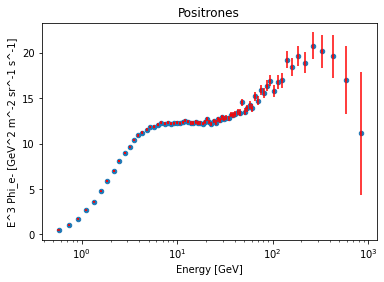

In [11]:
plt.scatter(data.E_bind, data.phi_E3, s = 20)
plt.errorbar(data.E_bind, data.phi_E3, xerr = data.E_bind_syst, yerr = data.phi_error_E3, fmt = 'None', ecolor = 'red')
plt.xscale('log')
plt.xlabel('Energy [GeV]')
plt.ylabel('E^3 Phi_e- [GeV^2 m^-2 sr^-1 s^-1]')
plt.title('Positrones')
plt.show()

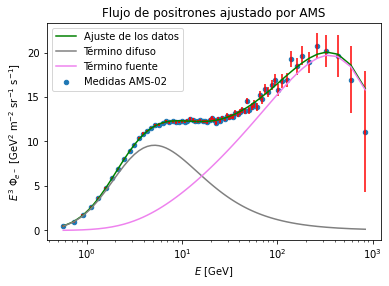

In [12]:
# plot + fits
plt.plot(data.E_bind,fit_tot*data.E_bind**3,c = 'green',label='Ajuste de los datos')
plt.plot(data.E_bind,fit_diff*data.E_bind**3,c = 'grey',label='Término difuso')
plt.plot(data.E_bind,fit_source*data.E_bind**3,c = 'violet',label='Término fuente')

plt.scatter(data.E_bind, data.phi_E3, s = 20,label='Medidas AMS-02')
plt.errorbar(data.E_bind, data.phi_E3, xerr = data.E_bind_syst, yerr = data.phi_error_E3, fmt = 'None', ecolor = 'red')
plt.xscale('log')
plt.xlabel('$E$ [GeV]')
plt.ylabel('$E^3$ $\Phi_{e^-}$ [GeV$^2$ m$^{-2}$ sr$^{-1}$ s$^{-1}$]')
plt.title('Flujo de positrones ajustado por AMS')
plt.legend()
plt.savefig('positrones')
plt.show()

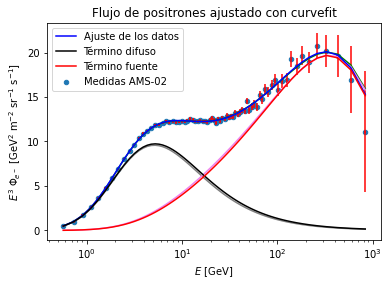

In [13]:
# plot + fits (parámetros dados y calculados)

plt.plot(data.E_bind,fit_tot*data.E_bind**3,c = 'green')
plt.plot(data.E_bind,fit_diff*data.E_bind**3,c = 'grey')
plt.plot(data.E_bind,fit_source*data.E_bind**3,c = 'violet')

plt.plot(data.E_bind,fit_tot_param*data.E_bind**3,c = 'blue',label='Ajuste de los datos')
plt.plot(data.E_bind,fit_diff_param*data.E_bind**3,c = 'black',label='Término difuso')
plt.plot(data.E_bind,fit_source_param*data.E_bind**3,c = 'red',label='Término fuente')

plt.scatter(data.E_bind, data.phi_E3, s = 20,label='Medidas AMS-02')
plt.errorbar(data.E_bind, data.phi_E3, xerr = data.E_bind_syst, yerr = data.phi_error_E3, fmt = 'None', ecolor = 'red')
plt.xscale('log')
plt.xlabel('$E$ [GeV]')
plt.ylabel('$E^3$ $\Phi_{e^-}$ [GeV$^2$ m$^{-2}$ sr$^{-1}$ s$^{-1}$]')
plt.title('Flujo de positrones ajustado con curvefit')
plt.legend()
plt.savefig('positrones_curvefit')
plt.show()

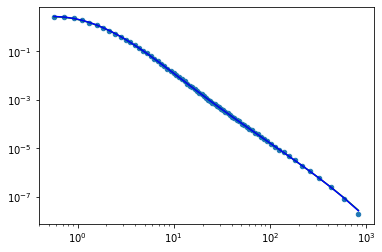

In [14]:
# plot + fits

plt.plot(data.E_bind,fit_tot,c = 'green')
# plt.plot(data.E_bind,fit_tot*data.E_bind**3,c = 'green')
# plt.plot(data.E_bind,fit_diff*data.E_bind**3,c = 'grey')
# plt.plot(data.E_bind,fit_source*data.E_bind**3,c = 'violet')

plt.plot(data.E_bind,fit_tot_param,c = 'blue')
# plt.plot(data.E_bind,fit_tot_param*data.E_bind**3,c = 'blue')
# plt.plot(data.E_bind,fit_diff_param*data.E_bind**3,c = 'black')
# plt.plot(data.E_bind,fit_source_param*data.E_bind**3,c = 'red')

plt.scatter(data.E_bind, data.phi, s = 20)
# plt.scatter(data.E_bind, data.phi_E3, s = 20)
# plt.errorbar(data.E_bind, data.phi_E3, xerr = data.E_bind_syst, yerr = data.phi_error_E3, fmt = 'None', ecolor = 'red')
plt.xscale('log')
plt.yscale('log')
# plt.xlabel('Energy [GeV]')
# plt.ylabel('E^3 Phi_e- [GeV^2 m^-2 sr^-1 s^-1]')
# plt.title('Positrones')
plt.show()

CONTRIBUCIÓN DE PULSARS

In [15]:
def diffusion(E,D0,gamma):
    return D0*(E/4)**gamma

In [16]:
def diff_distance(E,DE,t,gamma,Emax):
    return 2*np.sqrt( DE*t * (1-(1-E/Emax)**(1-gamma)) / ((1-gamma)*E/Emax) )

In [17]:
def integral(E,Emax,alpha,Ecut):
    return integrate.quad(lambda E: E**(1-alpha)*np.exp(-E/Ecut),1,Emax)

In [18]:
def Q0(E, Emax, alpha, Ec, Eout, fe, SpinDown, t, tau):
    return fe* SpinDown* t**2/tau /(integral(E, Emax, alpha, Ec)[0])

In [19]:
def flujo_pulsar(E,r,rdiff,t,Q0,a,alpha,Ec,gamma,Emax):
    c = 3*10**8* u.m/u.s
    cterm = c/(4*np.pi)
    qterm = Q0/(np.pi**(3/2)*r**3)
    rterm = (r/rdiff)**3 * np.exp(-(r/rdiff)**2)
    lossterm = (1-a*t*E)**(alpha-2) * np.exp(-E/((1-a*t*E)*Ec))
    alfaterm = E**(-alpha)
    
    phi = cterm * qterm * rterm * lossterm * alfaterm
    return phi

In [20]:
fact_conversion = {'years_s': 3.15576e7, 
                   'kpc_m': 1/(3.2408e-20), 
                   'cm2_m2': 1e-4, 
                   'erg_GeV': 6.242e2, 
                   'J_GeV': 6.242e9 
                  }

In [21]:
constantes = {'a': 1.4e-16 , 
              'tau': 1e4 * fact_conversion['years_s'], 
              'D0': 6.2e28 * fact_conversion['cm2_m2'],
              'gamma': 0.31
             }

GEMINGA

In [22]:
geminga = {'r': 0.25 * fact_conversion['kpc_m'], 
           't': 3.42e5 * fact_conversion['years_s'], 
           'alpha': 1.98, 
           'Ec': 1000, 
           'fe': 0.1,
           'Eout': 12.2*1e48 * fact_conversion['erg_GeV'],
           'SpinDown': 3.2e34 * fact_conversion['erg_GeV']
          }
geminga.setdefault('Emax',1/(constantes['a']*geminga['t']))
geminga.update(constantes)
print(geminga['Emax'])

661.8230537600031


In [23]:
# Emax es un valor que está incluido en el intervalo, sin embargo, las energías no pueden ser superiores a Emax.
# Hay que amputar

i = 0
Eg = np.array([])
while data.E_bind[i] < geminga['Emax']:
    Eg = np.append(Eg,data.E_bind[i])
    i += 1

In [24]:
geminga.setdefault('Q0', Q0(Eg, geminga['Emax'], geminga['alpha'], geminga['Ec'], geminga['Eout'], geminga['fe'], geminga['SpinDown'], geminga['t'], geminga['tau']))
geminga.setdefault('D(E)', diffusion(Eg, geminga['D0'], geminga['gamma']))
geminga.setdefault('rdiff',diff_distance(Eg, geminga['D(E)'], geminga['t'], geminga['gamma'], geminga['Emax']))
geminga.keys()

dict_keys(['r', 't', 'alpha', 'Ec', 'fe', 'Eout', 'SpinDown', 'Emax', 'a', 'tau', 'D0', 'gamma', 'Q0', 'D(E)', 'rdiff'])

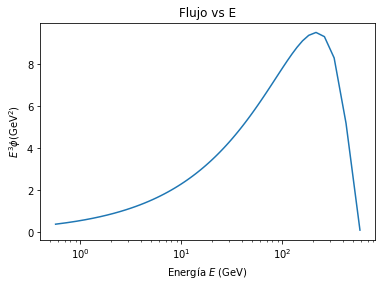

In [25]:
phi_geminga = 3.5*flujo_pulsar(Eg, geminga['r'], geminga['rdiff'], geminga['t'], geminga['Q0'], geminga['a'], 
                           geminga['alpha'], geminga['Ec'], geminga['gamma'], geminga['Emax'])

plt.plot(Eg,Eg**3*phi_geminga)
plt.title('Flujo vs E')
plt.xscale('log')
plt.xlabel('Energía $E$ (GeV)')
plt.ylabel('$E^3 \phi ($GeV$^2 )$')
plt.show()

MONOGEM

In [26]:
monogem = {'r':0.28 * fact_conversion['kpc_m'], 
           't': 1.11e5 * fact_conversion['years_s'], 
           'alpha': 1.9, 
           'Ec': 1000, 
           'fe': 0.18,
           'Eout': 1.6* 1e48 * fact_conversion['erg_GeV'],
           'SpinDown': 3.8e34 * fact_conversion['erg_GeV']
          }
monogem.setdefault('Emax',1/(constantes['a']*monogem['t']))
monogem.update(constantes)
print(monogem['Emax'])

2039.130489963253


In [27]:
monogem.setdefault('Q0', Q0(data.E_bind, monogem['Emax'], monogem['alpha'], monogem['Ec'], monogem['Eout'], monogem['fe'], monogem['SpinDown'], monogem['t'], monogem['tau']))
monogem.setdefault('D(E)', diffusion(data.E_bind, monogem['D0'], monogem['gamma']))
monogem.setdefault('rdiff',diff_distance(data.E_bind, monogem['D(E)'], monogem['t'], monogem['gamma'], monogem['Emax']))
monogem.keys()

dict_keys(['r', 't', 'alpha', 'Ec', 'fe', 'Eout', 'SpinDown', 'Emax', 'a', 'tau', 'D0', 'gamma', 'Q0', 'D(E)', 'rdiff'])

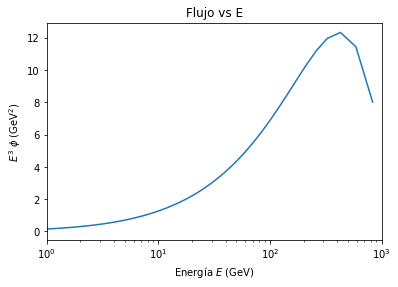

In [28]:
phi_monogem = 3*flujo_pulsar(data.E_bind, monogem['r'], monogem['rdiff'], monogem['t'], monogem['Q0'], monogem['a'], 
                           monogem['alpha'], monogem['Ec'], monogem['gamma'], monogem['Emax'])

plt.plot(data.E_bind,data.E_bind**3*phi_monogem)
plt.title('Flujo vs E')
plt.xscale('log')
plt.xlabel('Energía $E$ (GeV)')
plt.ylabel('$E^3$ $\phi$ (GeV$^2$)')
plt.xlim(1,1e3)
plt.show()

In [29]:
phi_geminga2 = np.append(np.array(phi_geminga),np.array(np.zeros(len(phi_monogem)-len(phi_geminga))))
phi_monogem = np.array(phi_monogem)
pulsars = phi_monogem + phi_geminga2

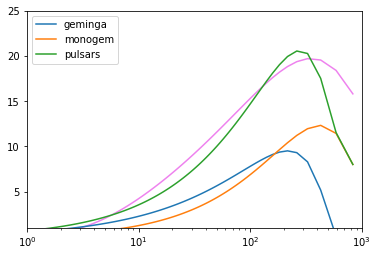

In [30]:
plt.plot(data.E_bind,fit_source*data.E_bind**3,c = 'violet')

plt.plot(data.E_bind,data.E_bind**3*phi_geminga2,label='geminga')
plt.plot(data.E_bind,data.E_bind**3*phi_monogem,label='monogem')
plt.plot(data.E_bind,data.E_bind**3*pulsars,label='pulsars')
plt.xscale('log')
plt.xlim(1,1e3)
plt.ylim(1,25)
#plt.yscale('log')
plt.legend()
plt.show()

In [31]:
pulsar_total = pulsars + fit_diff

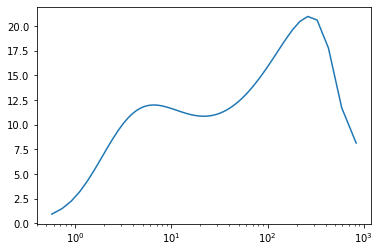

In [32]:
plt.plot(data.E_bind,data.E_bind**3*pulsar_total)
plt.xscale('log')
plt.show()

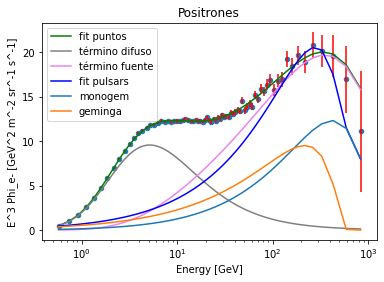

In [33]:
# plot + fits
plt.plot(data.E_bind,fit_tot*data.E_bind**3,c = 'green',label='fit puntos')
plt.plot(data.E_bind,fit_diff*data.E_bind**3,c = 'grey',label='término difuso')
plt.plot(data.E_bind,fit_source*data.E_bind**3,c = 'violet', label='término fuente')
plt.plot(data.E_bind,data.E_bind**3*pulsars,c = 'blue', label='fit pulsars')
#plt.plot(data.E_bind,data.E_bind**3*pulsar_total,c='yellow',label='fit pulsar + diff')
plt.plot(data.E_bind,data.E_bind**3*phi_monogem,label='monogem')
plt.plot(data.E_bind,data.E_bind**3*phi_geminga2,label='geminga')

plt.scatter(data.E_bind, data.phi_E3, s = 20)
plt.errorbar(data.E_bind, data.phi_E3, xerr = data.E_bind_syst, yerr = data.phi_error_E3, fmt = 'None', ecolor = 'red')
plt.xscale('log')
plt.xlabel('Energy [GeV]')
plt.ylabel('E^3 Phi_e- [GeV^2 m^-2 sr^-1 s^-1]')
plt.title('Positrones')
plt.legend()
plt.show()

In [34]:
fit_diff_pulsars = fit_tot - pulsars
for i in range(len(fit_diff_pulsars)):
    if fit_diff_pulsars[i]<=0 :
        fit_diff_pulsars[i:] = 0
        break
        
pulsar_total = pulsars + fit_diff_pulsars

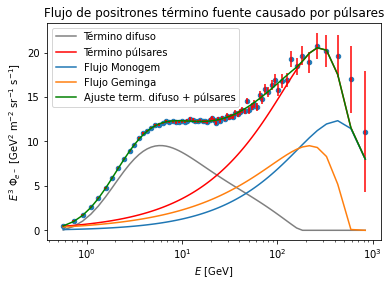

In [35]:
# plot + fits
#plt.plot(data.E_bind,fit_tot*data.E_bind**3,c = 'green',label='fit puntos')
plt.plot(data.E_bind,fit_diff_pulsars*data.E_bind**3,c = 'grey',label='Término difuso')
plt.plot(data.E_bind,data.E_bind**3*pulsars,c = 'red', label='Término púlsares')
plt.plot(data.E_bind,data.E_bind**3*phi_monogem,label='Flujo Monogem')
plt.plot(data.E_bind,data.E_bind**3*phi_geminga2,label='Flujo Geminga')
plt.plot(data.E_bind,data.E_bind**3*pulsar_total,c='green',label='Ajuste term. difuso + púlsares')

plt.scatter(data.E_bind, data.phi_E3, s = 20)
plt.errorbar(data.E_bind, data.phi_E3, xerr = data.E_bind_syst, yerr = data.phi_error_E3, fmt = 'None', ecolor = 'red')
plt.xscale('log')
plt.xlabel('$E$ [GeV]')
plt.ylabel('$E^3$ $\Phi_{e^-}$ [GeV$^2$ m$^{-2}$ sr$^{-1}$ s$^{-1}$]')
plt.title('Flujo de positrones término fuente causado por púlsares')
plt.legend()
plt.savefig('pulsares1')
plt.show()

Para los dos púlsares por separado

In [36]:
geminga['D0'], geminga['gamma'] = 4.2e27 * fact_conversion['cm2_m2'], 0.38
monogem['D0'], monogem['gamma'] = 4.2e27 * fact_conversion['cm2_m2'], 0.38

In [37]:
geminga['D(E)'] = diffusion(data.E_bind, geminga['D0'], geminga['gamma'])
geminga['rdiff'] = diff_distance(data.E_bind, geminga['D(E)'], geminga['t'], geminga['gamma'], geminga['Emax'])

In [38]:
monogem['D(E)'] = diffusion(data.E_bind, monogem['D0'], monogem['gamma'])
monogem['rdiff'] = diff_distance(data.E_bind, monogem['D(E)'], monogem['t'], monogem['gamma'], monogem['Emax'])

In [39]:
phi_geminga = 0.37*flujo_pulsar(data.E_bind, geminga['r'], geminga['rdiff'], geminga['t'], geminga['Q0'], geminga['a'], 
                           geminga['alpha'], geminga['Ec'], geminga['gamma'], geminga['Emax'])

In [40]:
phi_monogem = 0.75*flujo_pulsar(data.E_bind, monogem['r'], monogem['rdiff'], monogem['t'], monogem['Q0'], monogem['a'], 
                           monogem['alpha'], monogem['Ec'], monogem['gamma'], monogem['Emax'])

In [41]:
phi_geminga2 = np.append(np.array(phi_geminga),np.array(np.zeros(len(phi_monogem)-len(phi_geminga))))
phi_monogem = np.array(phi_monogem)
pulsars = phi_geminga2 + phi_monogem

In [42]:
fit_diff_pulsars = fit_tot - pulsars
for i in range(len(fit_diff_pulsars)):
    if fit_diff_pulsars[i]<=0 :
        fit_diff_pulsars[i:] = 0
        break
        
pulsar_total = pulsars + fit_diff_pulsars

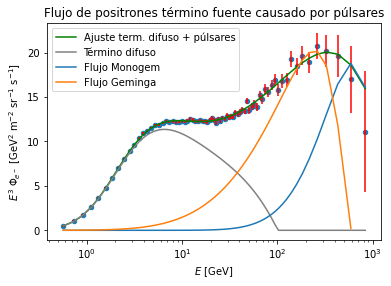

In [43]:
plt.plot(data.E_bind,fit_tot*data.E_bind**3,c = 'green',label='Ajuste term. difuso + púlsares')
plt.plot(data.E_bind,fit_diff_pulsars*data.E_bind**3,c = 'grey',label='Término difuso')
#plt.plot(data.E_bind,data.E_bind**3*pulsars,c = 'blue', label='fit pulsars')
#plt.plot(data.E_bind,data.E_bind**3*pulsar_total,c='green',label='fit pulsar + diff')
plt.plot(data.E_bind,data.E_bind**3*phi_monogem,label='Flujo Monogem')
plt.plot(data.E_bind,data.E_bind**3*phi_geminga2,label='Flujo Geminga')

plt.scatter(data.E_bind, data.phi_E3, s = 20)
plt.errorbar(data.E_bind, data.phi_E3, xerr = data.E_bind_syst, yerr = data.phi_error_E3, fmt = 'None', ecolor = 'red')
plt.xscale('log')
plt.xlabel('$E$ [GeV]')
plt.ylabel('$E^3$ $\Phi_{e^-}$ [GeV$^2$ m$^{-2}$ sr$^{-1}$ s$^{-1}$]')
plt.title('Flujo de positrones término fuente causado por púlsares')
plt.legend()
plt.savefig('pulsares2')
plt.show()